In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None

# wczytanie zbioru uczącego (mecze sezonu regularnego NBA z lat 1999-2019)
raw_data_train = pd.read_csv('~/nba-dl/data/matches/RS/book-RS.csv')
# wczytanie zbioru testowego (mecze play-off NBA z lat 1999-2019)
raw_data_test = pd.read_csv('~/nba-dl/data/matches/PO/book-PO.csv')

In [3]:
# wyświetlenie wymiarów zbiorów
print(raw_data_train.shape) # zbiór uczący
print(raw_data_test.shape)  # zbiór testowy

(24154, 41)
(1641, 41)


In [4]:
# wyświetlenie wszystkich kolumn - statystyk w obu zbiorach
print(list(raw_data_train.columns))

['SEASON_ID', 'HOME_TEAM_NAME', 'AWAY_TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'HWIN', 'HPLUSMINUS', 'HFGM', 'HFGA', 'HFG_PCT', 'HFG3M', 'HFG3A', 'HFG3_PCT', 'HFTM', 'HFTA', 'HFT_PCT', 'HOREB', 'HDREB', 'HREB', 'HAST', 'HSTL', 'HBLK', 'HTOV', 'HPF', 'AFGM', 'AFGA', 'AFG_PCT', 'AFG3M', 'AFG3A', 'AFG3_PCT', 'AFTM', 'AFTA', 'AFT_PCT', 'AOREB', 'ADREB', 'AREB', 'AAST', 'ASTL', 'ABLK', 'ATOV', 'APF']


In [5]:
# zmapowanie przewidywanej wielkości do wartości numerycznych
raw_data_train['HWIN'] = raw_data_train['HWIN'].map({'W': 1, 'L': 0})
raw_data_test['HWIN'] = raw_data_test['HWIN'].map({'W': 1, 'L': 0})

In [6]:
# podzielenie zbiorów na podzbiory X (wektor wejściowy ze statystykami) oraz Y(przewidywana wielkość)
X_train = raw_data_train.drop("HWIN", 1)
y_train = raw_data_train["HWIN"]
X_test = raw_data_test.drop("HWIN", 1)
y_test = raw_data_test['HWIN']

In [7]:
# utworzenie list znaczących statystyk dla każdej z metod badanej we wcześniejszym podrozdziale
pearson_correlation_features = ['HFGM', 'HFG_PCT', 'HDREB', 'HAST', 'AFGM', 'AFG_PCT', 'ADREB']
univariate_selection_features = ['HAST', 'AAST', 'ADREB', 'HDREB', 'HFGM', 'AFGM', 'AFG3M']
rfe_features = ['HFGM', 'HFG3M', 'HFG3_PCT', 'HFTM', 'AFGM', 'AFG3M', 'AFTM']
feature_importance_features = ['AFG_PCT', 'HFG_PCT', 'HFGM', 'AFGM', 'ADREB', 'HAST', 'HDREB']

In [8]:
# stworzenie słownika nazwa metody : lista dobranych przez nią statystyk
methods = {"Współczynnik korelacji Pearsona": pearson_correlation_features, 
           "Analiza jednoczynnikowa": univariate_selection_features, 
           "Rekursywna eliminacja cech": rfe_features, 
           "Ocena ważności zmiennych": feature_importance_features}

Nazwa metody: Współczynnik korelacji Pearsona
Znaczące statystyki: ['HFGM', 'HFG_PCT', 'HDREB', 'HAST', 'AFGM', 'AFG_PCT', 'ADREB']


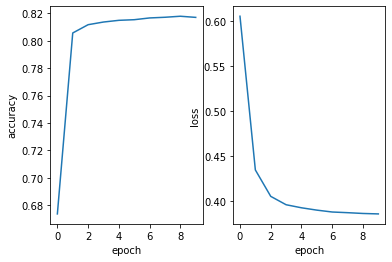

Skuteczność modelu na danych uczących: 81.71
Wartość funkcji kosztu na danych uczących: 0.39
Skuteczność modelu dla danych testowych: 83.61
--------------------------------------------
Nazwa metody: Analiza jednoczynnikowa
Znaczące statystyki: ['HAST', 'AAST', 'ADREB', 'HDREB', 'HFGM', 'AFGM', 'AFG3M']


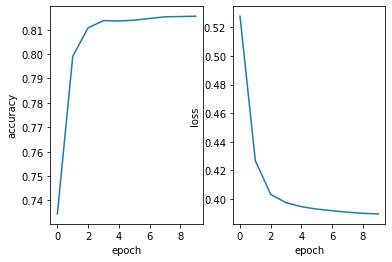

Skuteczność modelu na danych uczących: 81.55
Wartość funkcji kosztu na danych uczących: 0.39
Skuteczność modelu dla danych testowych: 82.88
--------------------------------------------
Nazwa metody: Rekursywna eliminacja cech
Znaczące statystyki: ['HFGM', 'HFG3M', 'HFG3_PCT', 'HFTM', 'AFGM', 'AFG3M', 'AFTM']


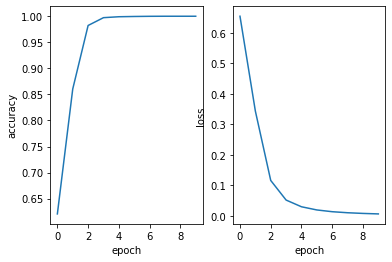

Skuteczność modelu na danych uczących: 100.0
Wartość funkcji kosztu na danych uczących: 0.01
Skuteczność modelu dla danych testowych: 97.81
--------------------------------------------
Nazwa metody: Ocena ważności zmiennych
Znaczące statystyki: ['AFG_PCT', 'HFG_PCT', 'HFGM', 'AFGM', 'ADREB', 'HAST', 'HDREB']


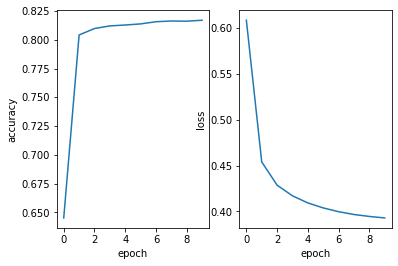

Skuteczność modelu na danych uczących: 81.7
Wartość funkcji kosztu na danych uczących: 0.39
Skuteczność modelu dla danych testowych: 83.18
--------------------------------------------


In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from keras.utils import np_utils
# porównanie
for method_name, features in methods.items():
    print("Nazwa metody: {}".format(method_name))
    print("Znaczące statystyki: {}".format(features))
    # stworzenie zbiorów uczących jedynie ze statystykami wybranymi w ramach badanej metody
    X_train_dataset = X_train[features]
    X_test_dataset = X_test[features]
    # stworzenie modelu sieci neuronowej
    model = Sequential()
    model.add(Dense(len(features), input_dim=len(features), activation='relu'))
    model.add(Dense(len(features), activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # standaryzacja danych
    scaler = StandardScaler()
    scaled_X_train= scaler.fit_transform(X_train_dataset)
    scaled_X_test = scaler.fit_transform(X_test_dataset)
    # zakodowanie wartości wielkości wyjściowej numerycznie
    encoder = LabelEncoder()
    encoder.fit(y_train)
    encoded_Y_train = encoder.transform(y_train)
    # konwersja do macierzy o liczbie kolumn równej liczbie możliwych wartości zmiennej wyjściowej
    dummy_y_train = np_utils.to_categorical(encoded_Y_train)
    # uczenie modelu na podstawie danych testowych
    res = model.fit(scaled_X_train, dummy_y_train, epochs=10, batch_size=100, verbose=0)
    accuracy = res.history['accuracy'][-1] # zapisanie skuteczności do zmiennej accuracy
    loss = res.history['loss'][-1]         # zapisanie wartości funkcji kosztu do zmiennej los
    # wykres skuteczności w kolejnych epokach
    plt.subplot(1,2,1)
    plt.plot(res.history['accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    # wykres wartości funkcji kosztu w kolejnych epokach
    plt.subplot(1,2,2)
    plt.plot(res.history['loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    print("Skuteczność modelu na danych uczących: {}".format(round(accuracy*100, 2)))
    print("Wartość funkcji kosztu na danych uczących: {}".format(round(loss, 2)))
    # przygotowanie wartości przewidywanej wielkości dla zbioru testowego
    encoder.fit(y_test)
    encoded_Y_test = encoder.transform(y_test)
    dummy_y_test = np_utils.to_categorical(encoded_Y_test)
    # sprawdzenie modelu z danymi testowymi
    scores = model.evaluate(scaled_X_test, dummy_y_test, verbose=0)
    validation = scores[1]                # zapisanie skuteczności do zmiennej validation
    print("Skuteczność modelu dla danych testowych: {}".format(round(validation*100, 2)))
    print("--------------------------------------------")